In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, cast, Date, distinct, extract

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite",echo=False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

inspector = inspect(engine)
inspector.get_table_names()

# reflect the tables

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found
inspector.get_table_names()

columns = inspector.get_columns('measurement')
print(f"measurement columns:")
for column in columns:
    print(column["name"], column["type"])

print("")

columns = inspector.get_columns('station')
print(f"station columns:")
for column in columns:
    print(column["name"], column["type"])


measurement columns:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station columns:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
session = Session(engine)


In [9]:
# Create our session (link) from Python to the DB
measure = session.query(Measurement.date).limit(10).all()
measure
station = session.query(Station.station).limit(10).all()
station


[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

# Exploratory Climate Analysis

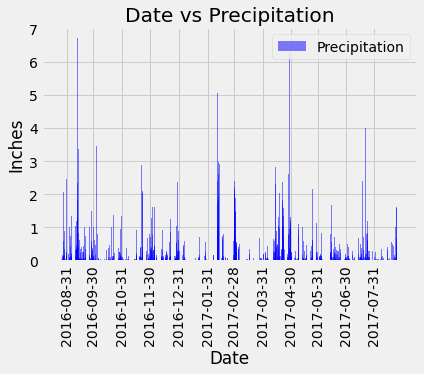

<Figure size 432x288 with 0 Axes>

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

maxDateList = session.query(func.max(func.date(Measurement.date).label('maxDate'))).first()
year, month, day = map(int, maxDateList[0].split('-'))
maxdate = dt.date(year, month, day)
# Get the 1 year ago date from the maximum date
maxDate1YearAgo = maxdate - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame Date must be after maxDate1YearAgo and prcp must be greate than 0
df = pd.read_sql(session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= maxDate1YearAgo).filter(Measurement.prcp >= 0).statement,session.bind)

prcpStat = df.set_index("date")
prcpStat.index.min()
prcpStat.prcp.min()

# Sort the dataframe by date
prcpStat.sort_index()

# Function to gather and return labels for the x axis as we don't want to display every date point
def getLabels(s,t):
    labels =[]
    # Every month for the given date range
    for x in pd.date_range(start=s, end=t, freq='1M'):
        labels.append(x.strftime("%Y-%m-%d"))
    #print(labels)
    return labels

xlabels = getLabels(prcpStat.index.min(),prcpStat.index.max())
x_axis = prcpStat.index
y_axis = prcpStat.prcp

# Use Pandas Plotting with Matplotlib to plot the data
plt.title("Date vs Precipitation")
plt.bar(x_axis,y_axis, color='b',alpha = 0.5, align="center")
plt.xlabel("Date")
plt.ylabel("Inches")
ax = plt.gca()
ax.legend(["Precipitation"])
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels,rotation="vertical")
plt.show()
plt.tight_layout() 


In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
import datetime as dt

# Get the maximum date from the Measurement Date column
maxDateList = session.query(func.max(Measurement.date)).first()
year, month, day = map(int, maxDateList[0].split('-'))
maxdate = dt.date(year, month, day)
# Get the 1 year ago date from the maximum date
maxDate1YearAgo = maxdate - dt.timedelta(days=365)

# Save the query results as a Pandas DataFrame Date must be after maxDate1YearAgo and prcp must be greate than 0
df = pd.read_sql(session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= maxDate1YearAgo).filter(Measurement.prcp >= 0).statement,session.bind)

print(f"Mean of precipitation is {df.prcp.mean()}")
print(f"Mean of precipitation is {df.prcp.median()}")
print(f"Variance of precipitation is {df.prcp.var()}")
print(f"Standard Deviation of precipitation is {df.prcp.std()}")
print(f"SEM of precipitation is {df.prcp.sem()}")

Mean of precipitation is 0.17727857496288996
Mean of precipitation is 0.02
Variance of precipitation is 0.21269575849618544
Standard Deviation of precipitation is 0.4611895038877028
SEM of precipitation is 0.010258792791451843


In [22]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).distinct(Station.station).count()

9

In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station).label('Station Count')).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(func.min(Measurement.tobs).label('Minimum Temp'),func.max(Measurement.tobs).label('Maximum Temp'),func.avg(Measurement.tobs).label('Average Temp')).filter(Measurement.station =='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 54., 32.,  9.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <BarContainer object of 12 artists>)

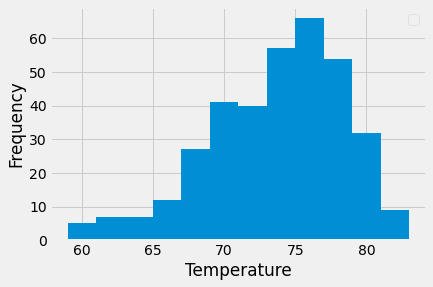

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Get the maximum date from the Measurement Date column for the most observed station
maxDateStation = session.query(func.max(Measurement.date)).filter(Measurement.station=='USC00519281').first()
year, month, day = map(int, maxDateStation[0].split('-'))
maxdate = dt.date(year, month, day)
# Get the 1 year ago date from the maximum date
maxDate1YearAgo = maxdate - dt.timedelta(days=365)
mostObsStation = pd.read_sql(session.query(Measurement.tobs).filter(Measurement.date >= maxDate1YearAgo).filter(Measurement.station == 'USC00519281').statement,session.bind)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend("Tobs")
plt.hist(mostObsStation.tobs,bins=12)

In [26]:
maxDateList = session.query(func.max(Measurement.date)).first()
year, month, day = map(int, maxDateList[0].split('-'))
year
lastYearMostActive = session.query(Measurement.station, func.count(Measurement.station).label('Station Count')).filter(extract('year',Measurement.date) == year).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
#session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == lastYearMostActive[0]).order_by(Measurement.date).all() 
results = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == lastYearMostActive[0]).filter(extract('year',Measurement.date) == year).order_by(Measurement.date).all() 
#results
allPrcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.prcp > 0).order_by(Measurement.date).all()
d = dict(allPrcp)
#('2010-02-22', 0.14),
# ('2010-02-22', 0.22),
# ('2010-02-23', 0.03),

#print(allPrcp[0][0])
#print(allPrcp[0][1])

#allPrcp.prcp
#allPrcp.date
#marks = {}.fromkeys(allPrcp.date, allPrcp.prcp)
#print(marks)
#for item in marks.items():
#    print(item)


## Bonus Challenge Assignment

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
            filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-02-28'))


[(66.0, 70.375, 73.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
